In [176]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree


# Read the CSV file into a DataFrame
df = pd.read_csv('cleaned.csv')

array([[<Axes: title={'center': 'antiInstPer'}>,
        <Axes: title={'center': 'policy'}>]], dtype=object)

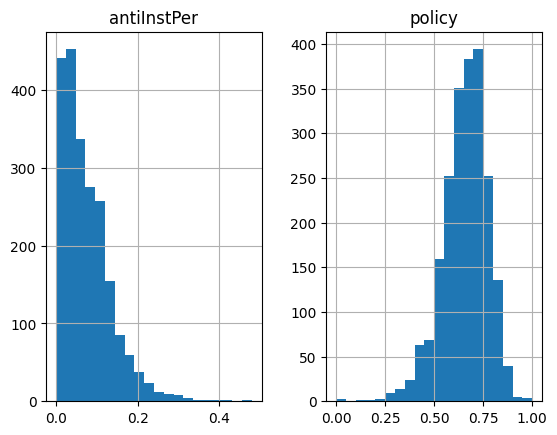

In [177]:
# Create a summary table
summary_table = df.describe()
summary_table
df[['antiInstPer', 'policy']].hist(bins=20) 

In [178]:
from sklearn.linear_model import Lasso
import seaborn as sns
# Drop rows with missing values

# Separate the independent variables (features) and the dependent variable (target)
y = df['policy']
X = df
# highlight features with highest multicollinearity
corr = X.corr()
corr_abs = corr.abs()

# Get the features with the highest multicollinearity
features_with_highest_multicollinearity = corr_abs.unstack().sort_values(ascending=False).drop_duplicates().head(15)

# Remove variables that are correlated to themselves
features_with_highest_multicollinearity = features_with_highest_multicollinearity[features_with_highest_multicollinearity.index.get_level_values(0) != features_with_highest_multicollinearity.index.get_level_values(1)]

# Print the features with the highest multicollinearity
print(features_with_highest_multicollinearity)

democrat       nominate_dim1    0.957582
medinc         economic         0.912814
economic       poverty          0.906188
GENERALD       dem_normal       0.892726
demHvote       GENERALD         0.890694
college        economic         0.877797
democrat       Inc_dem          0.873145
medinc         college          0.861496
nominate_dim1  Inc_dem          0.856106
dem_normal     demHvote         0.845546
nominate_dim1  dem_normal       0.834309
               GENERALD         0.830396
ideo5          pid7             0.817732
democrat       GENERALD         0.811884
dtype: float64


In [179]:
from sklearn.preprocessing import StandardScaler
# temporarily drop features with a lot of missing data to run PCA
X.drop(['PRIMARYD', 'PRIMARYR', 'GENERALD', 'wongeneralD', 'numcandsD', 'numcandsR'], axis=1, inplace=True)
X.dropna(inplace=True)

# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
# Convert the standardized array back to a DataFrame
X_standardized = pd.DataFrame(X_standardized, columns=X.columns)

X_standardized.dropna(inplace=True)
X_standardized.describe()

,year,southEast,policy,antiInstPer,posAffPer,affect,approval_pres,approval_rep,democrat,Inc_dem,...,college,nilf,medinc,gini,economic,demHvote,dem_normal,uncontested,primaryvote,primarychall
count,2.105000e+03,2.105000e+03,2.105000e+03,2.105000e+03,2.105000e+03,2.105000e+03,2.105000e+03,2.105000e+03,2.105000e+03,2.105000e+03,...,2.105000e+03,2.105000e+03,2.105000e+03,2.105000e+03,2.105000e+03,2.105000e+03,2.105000e+03,2.105000e+03,2.105000e+03,2.105000e+03
mean,7.301881e-14,-5.738350e-17,5.400800e-17,-1.215180e-16,-5.400800e-17,1.080160e-16,-4.725700e-17,-4.725700e-16,-4.388150e-17,-7.763650e-17,...,-3.848070e-16,1.805892e-16,4.333298e-16,1.264125e-15,-8.438750e-18,7.088550e-17,5.097005e-16,-2.953562e-17,3.999967e-16,5.738350e-17
std,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,...,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00
min,-1.414556e+00,-6.225810e-01,-5.802814e+00,-1.266027e+00,-1.608959e+00,-1.659623e+00,-2.844086e+00,-4.603671e+00,-1.010027e+00,-1.040239e+00,...,-2.247744e+00,-2.521403e+00,-1.952875e+00,-2.400330e+00,-3.473382e+00,-2.266877e+00,-2.068241e+00,-4.013216e-01,-3.642201e+00,-9.306668e-01
25%,-7.086194e-01,-6.225810e-01,-5.658167e-01,-7.831105e-01,-6.910549e-01,-8.006480e-01,-7.241042e-01,-6.523912e-01,-1.010027e+00,-1.040239e+00,...,-6.983085e-01,-6.280961e-01,-7.019140e-01,-6.958899e-01,-6.207531e-01,-6.639287e-01,-7.642242e-01,-4.013216e-01,-7.177572e-01,-5.043222e-01
50%,-2.682894e-03,-6.225810e-01,7.807642e-02,-2.114886e-01,-1.822170e-01,-1.990857e-01,3.351937e-02,2.128891e-02,9.900730e-01,9.613177e-01,...,-1.393201e-01,-8.516373e-02,-2.285513e-01,-9.866478e-02,-4.298313e-02,-1.013432e-01,-1.439971e-01,-4.013216e-01,1.935669e-01,-7.797752e-02
75%,7.032536e-01,1.606217e+00,7.011746e-01,5.274996e-01,4.513719e-01,6.310273e-01,7.085862e-01,6.390650e-01,9.900730e-01,9.613177e-01,...,6.211565e-01,5.351679e-01,5.331439e-01,4.851396e-01,6.514478e-01,6.435700e-01,6.782346e-01,-4.013216e-01,9.292210e-01,3.483671e-01
max,1.409190e+00,1.606217e+00,3.018522e+00,5.714528e+00,1.032379e+01,3.977241e+00,2.823500e+00,3.922310e+00,9.900730e-01,9.613177e-01,...,3.316821e+00,4.572423e+00,5.031403e+00,4.149014e+00,2.935870e+00,2.020052e+00,2.475753e+00,2.491767e+00,9.292210e-01,7.169881e+00


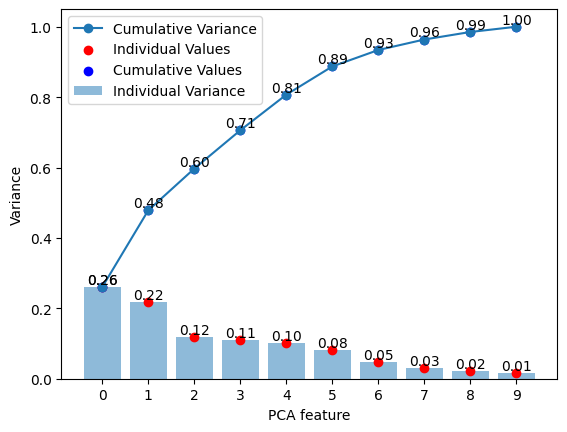

In [180]:
# Run a PCA and plot the explained variance ratio
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_standardized[['white', 'hispanic', 'black', 'educ', 'faminc', 'unionmember', 'ageless18', 'age65plus', 'armedforces', 'foreignborn']])
# Continue with PCA plot and feature selection

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, alpha=0.5, label='Individual Variance')
plt.plot(features, np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', label='Cumulative Variance')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.legend()

# Plot the data points
plt.scatter(features, pca.explained_variance_ratio_, c='red', label='Individual Values')
plt.scatter(features, np.cumsum(pca.explained_variance_ratio_), c='blue', label='Cumulative Values')

# Label each data point with its value
for i, var_ratio in enumerate(pca.explained_variance_ratio_):
    plt.text(features[i], var_ratio, f'{var_ratio:.2f}', ha='center', va='bottom')

for i, cum_var_ratio in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    plt.text(features[i], cum_var_ratio, f'{cum_var_ratio:.2f}', ha='center', va='bottom')

plt.legend()
plt.show()

pca_result = pca.transform(X_standardized[['white', 'hispanic', 'black', 'educ', 'faminc', 'unionmember', 'ageless18', 'age65plus', 'armedforces', 'foreignborn']])
X.drop(['white', 'hispanic', 'black', 'educ', 'faminc', 'unionmember', 'ageless18', 'age65plus', 'armedforces', 'foreignborn'], axis=1, inplace=True)

# select the PCA feature 5 and add it to X
for i in range(5):
    X[f'demoPCA{i + 1}'] = pca_result[:, i]

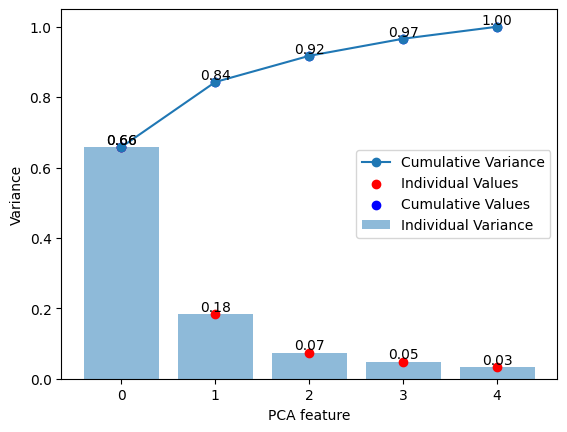

In [181]:
# Run a PCA and plot the explained variance ratio
pca = PCA()
pca.fit(X_standardized[['nominate_dim1', 'nominate_dim2', 'op_ideo', 'pid7', 'ideo5']])
# Continue with PCA plot and feature selection

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, alpha=0.5, label='Individual Variance')
plt.plot(features, np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', label='Cumulative Variance')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.legend()

# Plot the data points
plt.scatter(features, pca.explained_variance_ratio_, c='red', label='Individual Values')
plt.scatter(features, np.cumsum(pca.explained_variance_ratio_), c='blue', label='Cumulative Values')

# Label each data point with its value
for i, var_ratio in enumerate(pca.explained_variance_ratio_):
    plt.text(features[i], var_ratio, f'{var_ratio:.2f}', ha='center', va='bottom')

for i, cum_var_ratio in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    plt.text(features[i], cum_var_ratio, f'{cum_var_ratio:.2f}', ha='center', va='bottom')

plt.legend()
plt.show()

pca_result = pca.transform(X_standardized[['nominate_dim1', 'nominate_dim2', 'op_ideo', 'pid7', 'ideo5']])

# select the PCA feature 0 and add it to X
X['ideoPCA'] = pca.transform(X_standardized[['nominate_dim1', 'nominate_dim2', 'op_ideo', 'pid7', 'ideo5']])[:, 0]
X.drop(['nominate_dim1', 'nominate_dim2', 'op_ideo', 'pid7', 'ideo5'], axis=1, inplace=True)

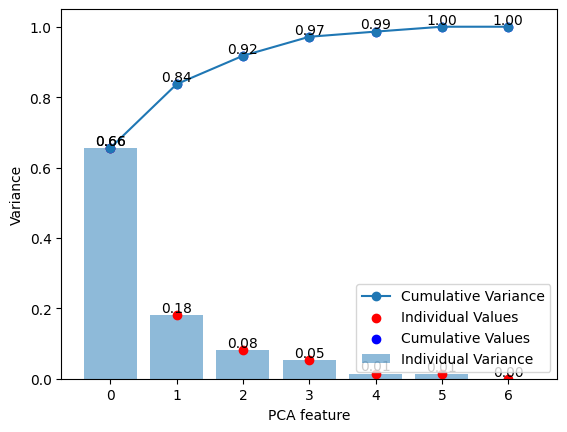

In [182]:
# Run a PCA and plot the explained variance ratio
pca = PCA()
pca.fit(X_standardized[['poverty', 'unemp_clf', 'college', 'nilf', 'medinc', 'gini', 'economic']])
# Continue with PCA plot and feature selection

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, alpha=0.5, label='Individual Variance')
plt.plot(features, np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', label='Cumulative Variance')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.legend()

# Plot the data points
plt.scatter(features, pca.explained_variance_ratio_, c='red', label='Individual Values')
plt.scatter(features, np.cumsum(pca.explained_variance_ratio_), c='blue', label='Cumulative Values')

# Label each data point with its value
for i, var_ratio in enumerate(pca.explained_variance_ratio_):
    plt.text(features[i], var_ratio, f'{var_ratio:.2f}', ha='center', va='bottom')

for i, cum_var_ratio in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    plt.text(features[i], cum_var_ratio, f'{cum_var_ratio:.2f}', ha='center', va='bottom')

plt.legend()
plt.show()

pca_result = pca.transform(X_standardized[['poverty', 'unemp_clf', 'college', 'nilf', 'medinc', 'gini', 'economic']])

X.drop(['poverty', 'unemp_clf', 'college', 'nilf', 'medinc', 'gini'], axis=1, inplace=True)


In [183]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif = pd.DataFrame()
X.drop(['dem_normal', 'approval_rep'], axis=1, inplace=True)
Xvif = X.drop(['policy'], axis=1)
vif["Feature"] = Xvif.columns
vif["VIF"] = [variance_inflation_factor(Xvif.values, i) for i in range(Xvif.shape[1])]

# Print the VIF values sorted from greatest to smallest
vif.sort_values(by='VIF', ascending=False)
print(vif)


          Feature         VIF
0            year  106.925295
1       southEast    1.580690
2     antiInstPer    7.953440
3       posAffPer    4.242718
4          affect   12.063895
5   approval_pres   46.827356
6        democrat   12.562764
7         Inc_dem   10.752775
8       seniority    2.811158
9        economic    2.926881
10       demHvote   21.729179
11    uncontested    1.216926
12    primaryvote   31.483952
13   primarychall    3.819861
14       demoPCA1    1.694440
15       demoPCA2    2.965737
16       demoPCA3    1.204829
17       demoPCA4    1.693186
18       demoPCA5    1.073034
19        ideoPCA    4.665633


In [184]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LassoCV


y = X['policy']
X.drop(['policy'], axis=1, inplace=True)
X.drop(['year'], axis=1, inplace=True)
print(X.columns)
X2 = X
y2 = y

Index(['southEast', 'antiInstPer', 'posAffPer', 'affect', 'approval_pres',
       'democrat', 'Inc_dem', 'seniority', 'economic', 'demHvote',
       'uncontested', 'primaryvote', 'primarychall', 'demoPCA1', 'demoPCA2',
       'demoPCA3', 'demoPCA4', 'demoPCA5', 'ideoPCA'],
      dtype='object')
Best alpha: 0.00012045035402587823
Best Test R-squared score: 0.2129817731989203


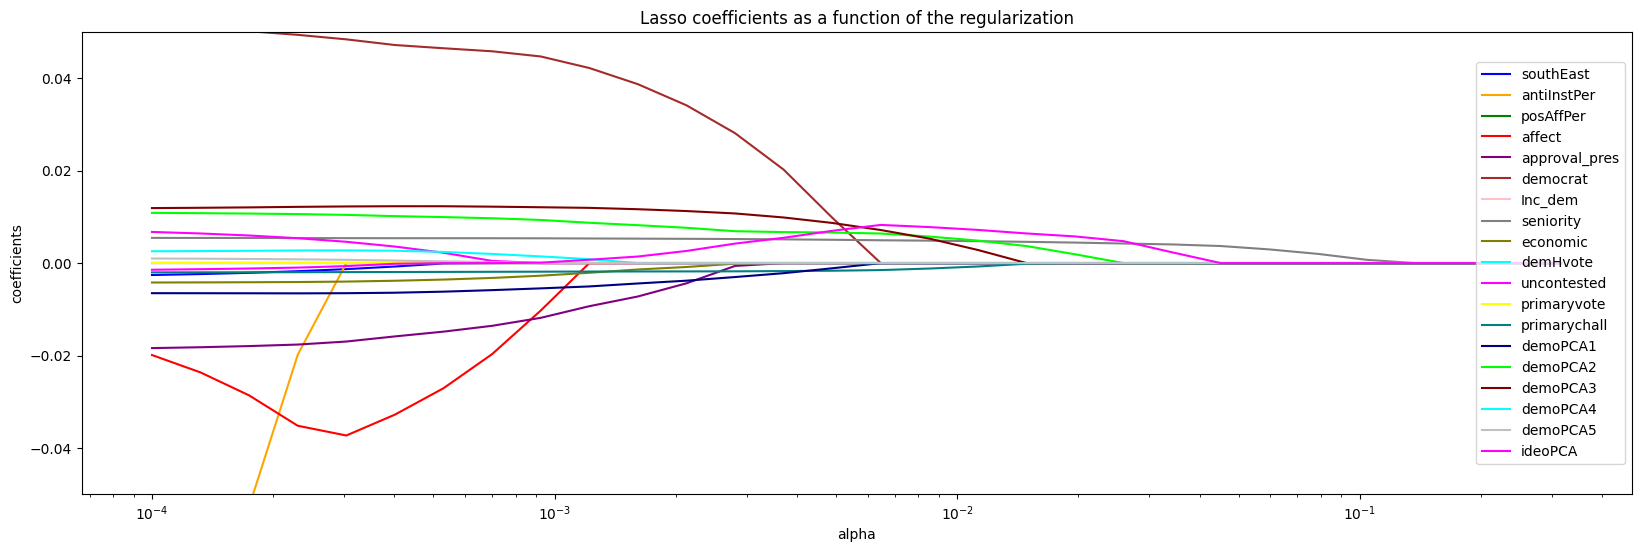

posAffPer
Inc_dem
demHvote
primaryvote
antiInstPer
ideoPCA
southEast
uncontested
affect
demoPCA5
demoPCA4
approval_pres
economic
democrat
demoPCA1
demoPCA3
primarychall
demoPCA2
seniority


In [185]:

# Set a range of alpha values
alphas = np.logspace(-4, -0.5, 30)

# Initialize an empty list to store coefficients for each alpha
coefs = []

# Define a color palette for the features
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'teal', 'navy', 'lime', 'maroon', 'aqua', 'silver', 'fuchsia', 'gold']

# Fit Lasso regression for each alpha and store coefficients
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X2, y2)
    coefs.append(lasso.coef_)

# Plot the results
plt.figure(figsize=(20, 6))

ax = plt.gca()
lines = ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')

# Assign different colors to the lines representing each feature
for i, line in enumerate(lines):
    line.set_color(colors[i % len(colors)])

plt.legend(X2.columns, loc='right')
plt.ylim([-0.05, 0.05])

plt.show()

zero_variables = []
seen_variable = []
for i, coef in enumerate(coefs):
    zero_indices = np.where(coef == 0)[0]
    zero_variables.extend(X2.columns[zero_indices])

# Print the variables in the order that they reach 0
for variable in zero_variables:
    if variable not in seen_variable:
        seen_variable.append(variable)
        print(variable)


In [186]:
X2.drop(['posAffPer', 'Inc_dem', 'demHvote', 'primaryvote', 'antiInstPer', 'ideoPCA', 'southEast'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X2 = sm.add_constant(X2)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold

n_folds = 15

# Initialize an empty list to store the R-squared scores
r2_scores = []

# Initialize an empty list to store the MSE scores
mse_scores = []

# Initialize an empty list to store the model coefficients
coefficients = []

# Create a KFold object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X2):
    X_train_fold, X_test_fold = X2.iloc[train_index], X2.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Add the constant term to the training data
    X_train_fold = sm.add_constant(X_train_fold)

    # Create a linear regression model
    linear_model = LinearRegression()

    # Fit the model to the training data
    linear_model.fit(X_train_fold, y_train_fold)

    # Add the constant term to the test data
    X_test_fold = sm.add_constant(X_test_fold)

    # Predict the target variable for the test data
    y_pred_fold = linear_model.predict(X_test_fold)

    # Calculate the R-squared score for the fold
    r2_fold = r2_score(y_test_fold, y_pred_fold)

    # Calculate the MSE for the fold
    mse_fold = mean_squared_error(y_test_fold, y_pred_fold)

    # Store the R-squared score and MSE for the fold
    r2_scores.append(r2_fold)
    mse_scores.append(mse_fold)

    # Store the model coefficients
    coefficients.append(linear_model.coef_)

# Calculate the average R-squared score and MSE across all folds
avg_r2_score = np.mean(r2_scores)
avg_mse_score = np.mean(mse_scores)

# Print the average R-squared score and MSE
print("Average R-squared score:", avg_r2_score)
print("Average Mean Squared Error:", avg_mse_score)

# Get the feature names
feature_names = X2.columns

# Initialize an empty list to store the average coefficients
avg_coefficients = []

# Calculate the average coefficient for each feature across all folds
for i in range(len(feature_names)):
    avg_coefficient = np.mean([coefficients[j][i] for j in range(n_folds)])
    avg_coefficients.append(avg_coefficient)

# Create the model string
model_string = "policy = "
for i, feature in enumerate(feature_names):
    model_string += f"{avg_coefficients[i]:.3f}{feature} + "
model_string = model_string[:-3]  # Remove the last " + "

print(model_string)


Out-of-Sample R-squared: 0.18627349382555936
Mean Squared Error: 0.009649046817168123
policy = -0.049const + -0.017affect + 0.046approval_pres + 0.005democrat + -0.005seniority + 0.011economic + -0.002uncontested + -0.007primarychall + 0.012demoPCA1 + 0.012demoPCA2 + 0.003demoPCA3 + 0.002demoPCA4
Average R-squared score: 0.13090023293628822
Average Mean Squared Error: 0.011038978794537881
policy = 0.000const + -0.050affect + -0.019approval_pres + 0.049democrat + 0.005seniority + -0.005economic + 0.008uncontested + -0.002primarychall + -0.007demoPCA1 + 0.011demoPCA2 + 0.013demoPCA3 + 0.004demoPCA4 + 0.001demoPCA5


In [187]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from xgboost import XGBRegressor 

df = pd.read_csv('cleaned.csv')

X = df.drop(['policy'], axis=1)
y = df['policy']

print(X.columns)

X = X.to_numpy()
y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the XGBoost regressor (use XGBRegressor for regression tasks)
xgb_model = XGBRegressor()

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'n_estimators': [1000],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=15)

# Fit the model to the training data with a validation dataset
grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Create an XGBoost model with the best parameters
best_xgb_model = XGBRegressor(**best_params)

# Fit the model to the training data with a validation dataset
best_xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=0)

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model using R-squared
r2 = r2_score(y_test, y_pred)
print("Best R-squared Score:", r2)
print("Best Hyperparameters:", best_params)
print("Best MSE:", -grid_search.best_score_)


Index(['year', 'southEast', 'antiInstPer', 'posAffPer', 'affect',
       'approval_pres', 'approval_rep', 'democrat', 'Inc_dem', 'seniority',
       'nominate_dim1', 'nominate_dim2', 'op_ideo', 'pid7', 'ideo5', 'white',
       'hispanic', 'black', 'educ', 'faminc', 'unionmember', 'ageless18',
       'age65plus', 'armedforces', 'foreignborn', 'poverty', 'unemp_clf',
       'college', 'nilf', 'medinc', 'gini', 'economic', 'demHvote',
       'dem_normal', 'uncontested', 'PRIMARYD', 'PRIMARYR', 'GENERALD',
       'wongeneralD', 'numcandsD', 'numcandsR', 'primaryvote', 'primarychall'],
      dtype='object')


KeyboardInterrupt: 